<br>

# Location Modeling using Neural Nets

### Notebook by [Marco Tavora](https://marcotavora.me/)

## Table of contents

1. [Introduction](#Introduction)
2. [Neural Nets](#Neural-Nets)

## Introduction
[[go back to the top]](#Table-of-contents)

From [Satman et al](http://www.ccsenet.org/journal/index.php/ijsp/article/view/32949):

> Selecting a location for a retail store is like an effort of estimating an unknown parameter without any data in some cases. Since the retail store does not exist, there is no data for demand and sales at hand, the decision maker is obliged to use auxiliary data which is collected by surveys, and/or, the data collected by other stores similar and near to the candidate in order to perform any statistical forecast, and/or, subjective comparisons of attributes. 

Data fetched using the `Google Places API` can be used to determine potential customers for a given area. Examples are
- The number of schools/universities is a proxy variable for educational structure of population
- Numbers of bus stations, gas stations, subway stations and taxi stands are proxies for transportation structure of the given area. 
- A high number of banks, atms, financial instutions is a sign of high daytime adult population 
- Large quantity of cafes, shopping malls and restaurants is related to young people at weekdays and families at weekends. 

Hence, quite generally, the environmental characteristics of a given area are related to the profile of its population. One can use this information to estimate the demand for new stores.

Following [Satman et al](http://www.ccsenet.org/journal/index.php/ijsp/article/view/32949) we can train artificial neural nets (ANN) to model the relation between environmental data and financial performance and use the ANN to forecast financial performances of new stores.

## Read Data
[[go back to the top]](#Table-of-contents)

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [117]:
df = pd.read_csv('environmental_data.csv')
df.head()

,index,bus_stations,restaurants,banks,ranking
0,1.0,26.0,18.0,32.0,D
1,2.0,54.0,9.0,9.0,C
2,3.0,30.0,30.0,33.0,B
3,4.0,39.0,14.0,52.0,C
4,5.0,19.0,35.0,18.0,B


In [118]:
df.dropna(inplace=True)

for col in df.iloc[:,:-1].columns:
    df[col] = [int(x) for 
               x in df[col]]
df.head()

,index,bus_stations,restaurants,banks,ranking
0,1,26,18,32,D
1,2,54,9,9,C
2,3,30,30,33,B
3,4,39,14,52,C
4,5,19,35,18,B


## Method
[[go back to the top]](#Table-of-contents)
- Build a neural net with environmental variables ( which areplaces types from the `Google Places API`) as inputs and rankings as output. 
- Examples of inputs are:
    - airport
    - amusement_park
    - aquarium
    - bus_station
- The output variable `ranking` is one of the labels A, B, C, D, E and must be encoded in binary vectors.

In [119]:
df.index = df['index']
df = df.iloc[:,1:]
dummies = pd.get_dummies(df['ranking'], 
                         drop_first=True)

In [115]:
df.head()
dummies.head()

,index,bus_stations,restaurants,banks,ranking
0,1,26,18,32,D
1,2,54,9,9,C
2,3,30,30,33,B
3,4,39,14,52,C
4,5,19,35,18,B


,B,C,D,E
index,,,,
1,0,0,1,0
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0
5,1,0,0,0


In [120]:
data = pd.concat([dummies, df.iloc[:,:-1]], axis=1)

data.head()

,B,C,D,E,bus_stations,restaurants,banks
index,,,,,,,
1,0,0,1,0,26,18,32
2,0,1,0,0,54,9,9
3,1,0,0,0,30,30,33
4,0,1,0,0,39,14,52
5,1,0,0,0,19,35,18


## Build ANN
[[go back to the top]](#Table-of-contents)

In [121]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
seed = 7
np.random.seed(seed)

In [125]:
X = data.iloc[:,4:].values
y = data.iloc[:,:4].values
print('X first 5 elements:')
X[0:5]
print('Y first 5 elements:')
y[0:5]

X first 5 elements:


array([[26, 18, 32],
       [54,  9,  9],
       [30, 30, 33],
       [39, 14, 52],
       [19, 35, 18]])

Y first 5 elements:


array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [126]:
from sklearn.model_selection import train_test_split

In [131]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=87)

In [132]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [137]:
X_train[0:5]
Y_train[0:5]

array([[ 0.63130522, -1.1381702 , -1.40028961],
       [ 1.59010707, -0.08575255, -1.11459396],
       [-0.89149772,  0.73279451, -0.54320266],
       [ 0.40570478, -0.72889667, -1.05745483],
       [ 1.02610598,  0.90819746,  0.37102342]])

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

In [141]:
input_dim = data.iloc[:,4:].shape[1]
output_dim = data.iloc[:,:4].shape[1]

input_dim, output_dim  

(3, 4)

In [202]:
num_classes = output_dim

def model_builder():
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, init='uniform', activation='softmax'))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model
    

model = model_builder()

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=20,verbose=-1)
scores = model.evaluate(X_test, Y_test, verbose=-1)
print("Error: %.2f%%" % (100-scores[1]*100))
    
train_loss = history.history['loss']
test_loss = history.history['val_loss']

Train on 150 samples, validate on 50 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Ep

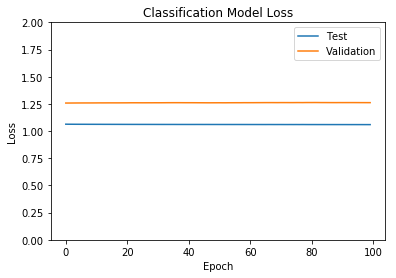

In [203]:
fig = plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.title('Classification Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(['Test', 'Validation'], loc='upper right')
fig.savefig('loss.png')
plt.show();